# Image Alignment & Calibration

- Image Alignment aka image Registration:
    - the process of transforming different images into the same coordinate system so they can be overlaid or compared pixel by pixel. 

- purpose:
    - Align photos taken from different angles or at different times.
    - support change detection, panorama stiching, 3D reconstruction, and motion tracking.

- method:
    - Feature-based: detect keypoints, match them, and estimate transformation(homography, affine)
    - Intensity-based: Use correlation or mutual information to align based on pixel values directly (used in medical imaging).

- Example: Aligning a satellite image taken today with one from a month ago to detect changes in forest cover. 


- Image Calibration:
    - the process of correcting for distortions and biases introduced by the image system(camera, lens, sensor)

- purpose:
    - remove lens distortion
    - Estimate intrinsic(focal-length, distortion, optical-center) and extrinsic (rotation, translation) camera parameters
    - improve accuracy for 3D reconstruction or measurements




In [1]:
import cv2
import exiftool
import os, glob
import numpy as np
import pyzbar.pyzbar as pyzbar
import matplotlib.pyplot as plt
import mapboxgl
from micasense.image import Image
from micasense.panel import Panel
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

## ENV SETUP


In [24]:
if os.name == 'nt':
    if os.environ.get('exiftoolpath') is None:
        print("Set the `exiftoolpath` environment variable as described above")
    else:
        if not os.path.isfile(os.environ.get('exiftoolpath')):
            print("The provided exiftoolpath isn't a file, check the settings")

try:
    with exiftool.ExifTool(os.environ.get('exiftoolpath')) as exift:
        print('Successfully executed exiftool.')
except Exception as e:
    print("Exiftool isn't working. Double check that you've followed the instructions above.")
    print("The execption text below may help to find the source of the problem:")
    print()
    print(e)

Successfully executed exiftool.


image name /Users/seaqueue/Documents/AI/Research/blueberry/understand_HSI/MicaSense/imageprocessing/data/ALTUM


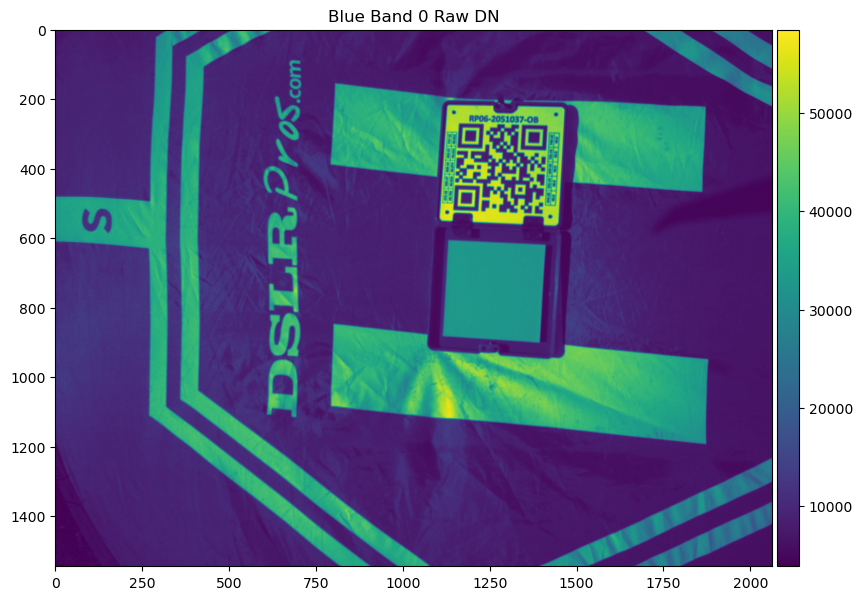

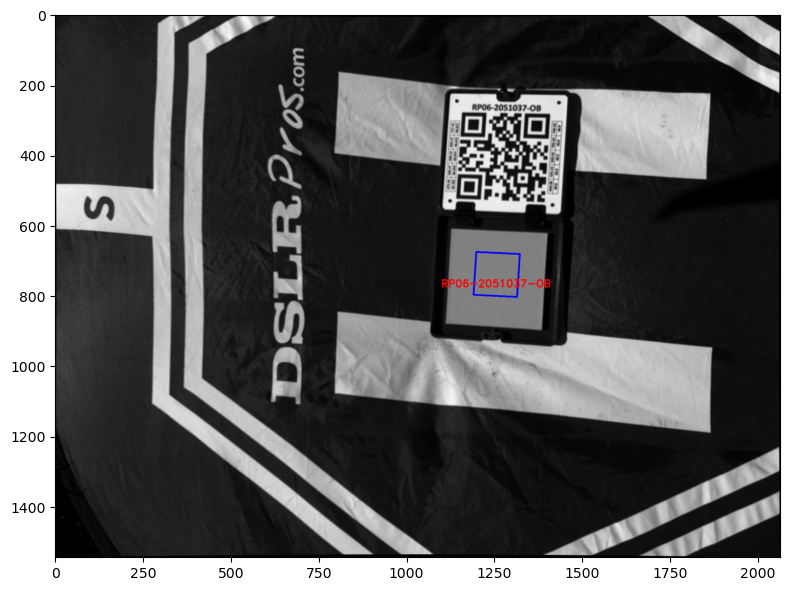

Success! Now you are ready for Part 1 of the tutorial.


In [25]:
imagePath = os.path.join('/Users/seaqueue/Documents/AI/Research/blueberry/understand_HSI/MicaSense/imageprocessing','data','ALTUM')
print('image name', imagePath)
imageName = glob.glob(os.path.join(imagePath,'IMG_0000_1.tif'))[0]
img = Image(imageName)
img.plot_raw(figsize=(8.73,8.73));

panel = Panel(img)
if not panel.panel_detected():
    raise IOError("Panel Not Detected! Check your installation of pyzbar")
else:
    panel.plot(figsize=(8,8));

print('Success! Now you are ready for Part 1 of the tutorial.')

## Blueberry - Active Image Alignment

- Each band of a multispectral capture must be aligned with the other bands in order to create meaningful data. 
- Image alignment allows the combination of images into true-color (RGB) and false color (such as CIR) composites.
- Alignment allows the calculation of pixel-accurate indices such as NDVI or NDRE at the single image level which can be very useful for applications like plant 
  counting and coverage estimations, where mosaicing artifacts may otherwise skew analysis results.


### Panel and Panel_reflectance_by_band

- Converting raw radiance data to reflectance data using calibration information.  

1. The Role of a Calibration Panel
  -	Definition: a panel refers to a calibration target (a physical reference panel) whose reflectance properties (i.e., how much light it reflects at each 
                wavelength) are known in advance.  
  -	Purpose: When you capture multispectral images, environmental lighting conditions can vary, and raw sensor readings (radiance) might not directly represent 
             true surface reflectance. By including images of a known calibration panel during a flight or imaging session, you can correct for lighting 
             conditions and sensor variabilities.  

2. Understanding “panel_reflectance_by_band”
	-	Definition: A list contains the known reflectance values of the calibration panel for each spectral band that the camera captures.
	- Automatic: Extract panel reflectance values from the metadata in the panel images using the method panelCap.panel_albedo().
  - Manual: If the metadata is missing or from an older firmware version (e.g., before Altum 1.3.5 or RedEdge 5.1.7): [0.49, 0.49, 0.49, 0.49, 0.49]. This list 
            suggests that each band’s calibration panel is assumed to reflect 49% of the light.
  - Purpose: The known reflectance values are used to compute the irradiance (the incident light energy) on the panel. This computed irradiance is then used to 
             convert the radiance values in your target images to reflectance values reliably.

285
IMG_0236
[PosixPath('/Users/seaqueue/Downloads/blueberry/multispectral/IMG_0236_3.tif'), PosixPath('/Users/seaqueue/Downloads/blueberry/multispectral/IMG_0236_2.tif'), PosixPath('/Users/seaqueue/Downloads/blueberry/multispectral/IMG_0236_1.tif'), PosixPath('/Users/seaqueue/Downloads/blueberry/multispectral/IMG_0236_5.tif'), PosixPath('/Users/seaqueue/Downloads/blueberry/multispectral/IMG_0236_4.tif')]

Processing set: IMG_0236
  - IMG_0236_1.tif
  - IMG_0236_2.tif
  - IMG_0236_3.tif
  - IMG_0236_4.tif
  - IMG_0236_5.tif


In [38]:
import micasense.capture as capture
%matplotlib inline
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "w"
import cv2
import numpy as np
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils
import imageio
from pathlib import Path
from collections import defaultdict

# Path to your image folder
image_folder = Path("/Users/seaqueue/Downloads/blueberry/multispectral")

# Find all .tif images
all_images = list(image_folder.glob("IMG_*_[1-5].tif"))

# Group images by shared base name (e.g., IMG_0000)
grouped = defaultdict(list)

for img_path in all_images:
    # Extract shared prefix: IMG_0000 from IMG_0000_1.tif
    base_name = "_".join(img_path.stem.split("_")[:2])
    grouped[base_name].append(img_path)
    
print('num of multispectral images', len(grouped))

# Only process groups with exactly 5 images
for base_name, image_paths in grouped.items():
    if len(image_paths) != 5:
        print(f"Skipping {base_name}: found only {len(image_paths)} bands")
        continue

    # Sort to ensure consistent band order: 1 to 5
    image_paths = sorted(image_paths, key=lambda p: int(p.stem.split("_")[-1]))
    imageNames =  [str(p.resolve()) for p in image_paths]
    print(imageNames)
    
    # panelNames = list(panelPath.glob('IMG.tif'))
    # panelNames = [x.as_posix() for x in panelNames]
    # Use Downwelling Light Sensor (DLS)
    panelNames = None

    # Allow this code to align both radiance and reflectance images; bu excluding
    # a definition for panelNames above, radiance images will be used
    # For panel images, efforts will be made to automatically extract the panel information
    # but if the panel/firmware is before Altum 1.3.5, RedEdge 5.1.7 the panel reflectance
    # will need to be set in the panel_reflectance_by_band variable.
    # Note: radiance images will not be used to properly create NDVI/NDRE images below.
    # if panelNames is not None:
    #     print('panelName is not None')
    #     panelCap = capture.Capture.from_filelist(panelNames)
    # else:
    #     print('panel name is None')
    #     panelCap = None

    cap = capture.Capture.from_filelist(imageNames)

    # if panelCap is not None:
    #     if panelCap.panel_albedo() is not None:
    #         panel_reflectance_by_band = panelCap.panel_albedo()
    #         print('using known reflectance!', panel_reflectance_by_band)
    #     else:
    #         panel_reflectance_by_band = [0.49, 0.49, 0.49, 0.49, 0.49]
    #         print('using manual reflectance!', panel_reflectance_by_band)
    #     panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)    
    #     img_type = "reflectance"
    #     cap.plot_undistorted_reflectance(panel_irradiance)
    # else:
    #     # Use Downwelling Light Sensor (DLS)
    #     if cap.dls_present():
    #         print('dls is present')
    #         img_type='reflectance'
    #         cap.plot_undistorted_reflectance(cap.dls_irradiance())
    #     else:
    #         print('dls is not present')
    #         img_type = "radiance"
    #         cap.plot_undistorted_radiance()  

    
    # --------------------------------- alignment Settings ---------------------------------
    match_index = 1 # Index of the band 
    max_alignment_iterations = 10
    warp_mode = cv2.MOTION_HOMOGRAPHY # MOTION_HOMOGRAPHY or MOTION_AFFINE. For Altum images only use HOMOGRAPHY
    pyramid_levels = 0 # for images with RigRelatives, setting this to 0 or 1 may improve alignment

    # print("Aligning images. Depending on settings this can take from a few seconds to many minutes")
    # Can potentially increase max_iterations for better results, but longer runtimes
    warp_matrices, alignment_pairs = imageutils.align_capture(cap,
                                                            ref_index = match_index,
                                                            max_iterations = max_alignment_iterations,
                                                            warp_mode = warp_mode,
                                                            pyramid_levels = pyramid_levels)
    print(f'{base_name} aligment done!')

    
    # --------------------------------- crop align images ---------------------------------
    cropped_dimensions, edges = imageutils.find_crop_bounds(cap, warp_matrices, warp_mode=warp_mode, reference_band=match_index)
    im_aligned = imageutils.aligned_capture(cap, warp_matrices, warp_mode, cropped_dimensions, match_index)
    
    print(f'{base_name} crop align done!')


  
    # --------------------------------- visualize aligned images ---------------------------------
    # figsize=(30,23) # use this size for full-image-resolution display
    # figsize=(16,13)   # use this size for export-sized display

    rgb_band_indices = [cap.band_names_lower().index('red'),
                        cap.band_names_lower().index('green'),
                        cap.band_names_lower().index('blue')]
    cir_band_indices = [cap.band_names_lower().index('nir'),
                        cap.band_names_lower().index('red'),
                        cap.band_names_lower().index('green')]

    # Create a normalized stack for viewing
    im_display = np.zeros((im_aligned.shape[0],im_aligned.shape[1],im_aligned.shape[2]), dtype=np.float32 )

    im_min = np.percentile(im_aligned[:,:,rgb_band_indices].flatten(), 0.5)  # modify these percentiles to adjust contrast
    im_max = np.percentile(im_aligned[:,:,rgb_band_indices].flatten(), 99.5)  # for many images, 0.5 and 99.5 are good values

    # for rgb true color, we use the same min and max scaling across the 3 bands to 
    # maintain the "white balance" of the calibrated image
    for i in rgb_band_indices:
        im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i], im_min, im_max)

    rgb = im_display[:,:,rgb_band_indices]

    # for cir false color imagery, we normalize the NIR,R,G bands within themselves, which provides
    # the classical CIR rendering where plants are red and soil takes on a blue tint
    # for i in cir_band_indices:
    #     im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])

    # cir = im_display[:,:,cir_band_indices]
    # fig, axes = plt.subplots(1, 2, figsize=figsize)
    # axes[0].set_title("Red-Green-Blue Composite")
    # axes[0].imshow(rgb)
    # axes[1].set_title("Color Infrared (CIR) Composite")
    # axes[1].imshow(cir)
    # plt.show()

    
    # --------------------------------- Image enhancement ---------------------------------
    # Create an enhanced version of the RGB render using an unsharp mask
    gaussian_rgb = cv2.GaussianBlur(rgb, (9,9), 10.0)
    gaussian_rgb[gaussian_rgb<0] = 0
    gaussian_rgb[gaussian_rgb>1] = 1
    unsharp_rgb = cv2.addWeighted(rgb, 1.5, gaussian_rgb, -0.5, 0)
    unsharp_rgb[unsharp_rgb<0] = 0
    unsharp_rgb[unsharp_rgb>1] = 1

    # Apply a gamma correction to make the render appear closer to what our eyes would see
    gamma = 1.4
    gamma_corr_rgb = unsharp_rgb**(1.0/gamma)
    # fig = plt.figure(figsize=figsize)
    # plt.imshow(gamma_corr_rgb, aspect='equal')
    # plt.axis('off')
    # plt.show()


    # --------------------------------- Image export ---------------------------------
    imtype = 'png' # or 'jpg'
    imageio.imwrite(f'/Users/seaqueue/Downloads/blueberry/rgb/{base_name}_rgb.'+imtype, (255*gamma_corr_rgb).astype('uint8'))
    # imageio.imwrite('cir_dls.'+imtype, (255*cir).astype('uint8'))
    print(f'{base_name}_rgb.png saved')

num of multispectral images 285
['/Users/seaqueue/Downloads/blueberry/multispectral/IMG_0236_1.tif', '/Users/seaqueue/Downloads/blueberry/multispectral/IMG_0236_2.tif', '/Users/seaqueue/Downloads/blueberry/multispectral/IMG_0236_3.tif', '/Users/seaqueue/Downloads/blueberry/multispectral/IMG_0236_4.tif', '/Users/seaqueue/Downloads/blueberry/multispectral/IMG_0236_5.tif']
Finished aligning band 1
Finished aligning band 3
Finished aligning band 0
Finished aligning band 4
Finished aligning band 2
IMG_0236 aligment done!
IMG_0236 crop align done!
IMG_0236_rgb.png saved
['/Users/seaqueue/Downloads/blueberry/multispectral/IMG_0273_1.tif', '/Users/seaqueue/Downloads/blueberry/multispectral/IMG_0273_2.tif', '/Users/seaqueue/Downloads/blueberry/multispectral/IMG_0273_3.tif', '/Users/seaqueue/Downloads/blueberry/multispectral/IMG_0273_4.tif', '/Users/seaqueue/Downloads/blueberry/multispectral/IMG_0273_5.tif']
Finished aligning band 1
Finished aligning band 4
Finished aligning band 0
Finished alig